In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import (
    SegformerForSemanticSegmentation,
    SegformerImageProcessor,
    TrainingArguments,
    Trainer
)
from PIL import Image
import tifffile as tiff
import torchmetrics
from sklearn.model_selection import train_test_split

# === CONFIGURATION ===
DATA_PATH = "data"
IMAGE_DIR = os.path.join(DATA_PATH, "images")  # Path to TIFF images
LABEL_DIR = os.path.join(DATA_PATH, "filtered_labels")  # Path to PNG masks
OUTPUT_DIR = "segformer_waterbody_output"
IMAGE_SIZE = (1024, 1024)  # Resize all images to this size
NUM_CLASSES = 2  # Background + Waterbody

# === SET DEVICE ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === IMAGE PROCESSOR ===
processor = SegformerImageProcessor(do_reduce_labels=True, size=IMAGE_SIZE)

# === DATASET CLASS ===
class WaterbodyDataset(Dataset):
    def __init__(self, image_files, label_files, image_dir, label_dir, processor):
        self.image_files = image_files
        self.label_files = label_files
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.label_dir, self.label_files[idx])

        # Load TIFF image
        image = tiff.imread(img_path)

        # Ensure 3-channel RGB format
        if len(image.shape) == 3 and image.shape[0] >= 3:
            image = image[:3, :, :]  # Select only the first 3 channels
            image = np.transpose(image, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
        else:
            raise ValueError(f"Unexpected image shape: {image.shape} in {img_path}")

        # Convert to PIL image and resize
        image = Image.fromarray(image.astype(np.uint8)).resize(IMAGE_SIZE)

        # Load mask and convert to grayscale
        mask = Image.open(mask_path).convert("L").resize(IMAGE_SIZE)
        mask = np.array(mask, dtype=np.uint8)

        # Normalize pixel values
        encoding = self.processor(image, return_tensors="pt")
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)  # Remove batch dim
        encoding["labels"] = torch.tensor(mask, dtype=torch.long)

        return encoding

# === SPLIT DATA INTO TRAIN/VAL/TEST ===
all_images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".tif")])
all_labels = sorted([f for f in os.listdir(LABEL_DIR) if f.endswith(".png")])

# 80% train, 10% validation, 10% test
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

# Create dataset objects
train_dataset = WaterbodyDataset(train_images, train_labels, IMAGE_DIR, LABEL_DIR, processor)
val_dataset = WaterbodyDataset(val_images, val_labels, IMAGE_DIR, LABEL_DIR, processor)
test_dataset = WaterbodyDataset(test_images, test_labels, IMAGE_DIR, LABEL_DIR, processor)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# === LOAD PRETRAINED SEGFORMER MODEL ===
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b1-finetuned-cityscapes-1024-1024",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)

    # Ensure predictions match label shape (upsample)
    predictions = torch.nn.functional.interpolate(
        predictions.unsqueeze(1).float(),  # Add channel dim for interpolation
        size=(1024, 1024),
        mode="bilinear",
        align_corners=False
    ).squeeze(1).long()  # Remove channel dim

    iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(device)
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)

    return {
        "mean_iou": iou(predictions, torch.tensor(labels).to(device)).item(),
        "f1_score": f1(predictions, torch.tensor(labels).to(device)).item(),
        "precision": precision(predictions, torch.tensor(labels).to(device)).item(),
        "recall": recall(predictions, torch.tensor(labels).to(device)).item(),
    }

# === TRAINING ARGUMENTS ===
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",  # Evaluate at steps
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,  # Log every 10 steps
)

# === TRAINER ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Now using validation dataset!
    compute_metrics=compute_metrics,
)

# === TRAIN MODEL ===
trainer.train()

# === SAVE TRAINED MODEL ===
model.save_pretrained(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)

print(f"✅ Model saved to {OUTPUT_DIR}")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Mean Iou,F1 Score,Precision,Recall
10,0.652600,0.608263,0.391587,0.461933,0.579196,0.509536
20,0.633800,0.619315,0.425301,0.528011,0.597128,0.538924
30,0.625700,0.567084,0.476735,0.594780,0.688549,0.587532
40,0.601000,0.533188,0.532424,0.666773,0.696714,0.652690
50,0.581300,0.490871,0.536777,0.668184,0.719540,0.649983
60,0.544200,0.505802,0.557768,0.707522,0.700667,0.759001
70,0.540500,0.484992,0.560387,0.700716,0.699381,0.702117
80,0.549700,0.476839,0.543326,0.677983,0.706925,0.663444
90,0.559100,0.528943,0.534926,0.678652,0.673702,0.685072
100,0.551400,0.478378,0.524162,0.660030,0.680902,0.648824


✅ Model saved to segformer_waterbody_output


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_heatmap(image, ground_truth, prediction):
    """
    Plots the input image, ground truth mask, and predicted mask as heatmaps.
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image
    ax[0].imshow(image.transpose(1, 2, 0))  # Assuming (C, H, W) → Convert to (H, W, C)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    # Ground Truth Mask
    sns.heatmap(ground_truth, cmap="Blues", alpha=0.7, cbar=False, ax=ax[1])
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    # Predicted Mask
    sns.heatmap(prediction, cmap="Reds", alpha=0.7, cbar=False, ax=ax[2])
    ax[2].set_title("Predicted Mask")
    ax[2].axis("off")

    plt.show()


In [8]:
import os
import torch
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import tifffile as tiff
import numpy as np

# === CONFIGURATION ===
DATA_PATH = "data"
IMAGE_DIR = os.path.join(DATA_PATH, "images")  # Path to TIFF images
LABEL_DIR = os.path.join(DATA_PATH, "filtered_labels")  # Path to PNG masks
OUTPUT_DIR = "segformer_waterbody_output"
IMAGE_SIZE = (1024, 1024)  # Resize all images to this size
NUM_CLASSES = 2  # Background + Waterbody

# === SET DEVICE ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === LOAD SAVED MODEL & PROCESSOR ===
model = SegformerForSemanticSegmentation.from_pretrained(OUTPUT_DIR).to(device)
processor = SegformerImageProcessor.from_pretrained(OUTPUT_DIR)

# === DATASET CLASS ===
class WaterbodyDataset(Dataset):
    def __init__(self, image_files, label_files, image_dir, label_dir, processor):
        self.image_files = image_files
        self.label_files = label_files
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.label_dir, self.label_files[idx])

        # Load TIFF image
        image = tiff.imread(img_path)

        # Ensure 3-channel RGB format
        if len(image.shape) == 3 and image.shape[0] >= 3:
            image = image[:3, :, :]  # Select only the first 3 channels
            image = np.transpose(image, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
        else:
            raise ValueError(f"Unexpected image shape: {image.shape} in {img_path}")

        # Convert to PIL image and resize
        image = Image.fromarray(image.astype(np.uint8)).resize(IMAGE_SIZE)

        # Load mask and convert to grayscale
        mask = Image.open(mask_path).convert("L").resize(IMAGE_SIZE)
        mask = np.array(mask, dtype=np.uint8)

        # Normalize pixel values
        encoding = self.processor(image, return_tensors="pt")
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)  # Remove batch dim
        encoding["labels"] = torch.tensor(mask, dtype=torch.long)

        return encoding

# === RELOAD TEST DATA ===
all_images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".tif")])
all_labels = sorted([f for f in os.listdir(LABEL_DIR) if f.endswith(".png")])

from sklearn.model_selection import train_test_split
_, test_images, _, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)
_, test_images, _, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

# Create test dataset & dataloader
test_dataset = WaterbodyDataset(test_images, test_labels, IMAGE_DIR, LABEL_DIR, processor)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# === EVALUATION METRICS ===
iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(device)
f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)

# === RUN INFERENCE ===
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch["pixel_values"].to(device)  # Input images
        labels = batch["labels"].to(device)  # Ground truth masks

        outputs = model(pixel_values)  # Model predictions
        logits = outputs.logits  # Get raw logits

        # Upsample predictions to match label size
        preds = torch.nn.functional.interpolate(
            logits, size=(1024, 1024), mode="bilinear", align_corners=False
        )
        preds = torch.argmax(preds, dim=1)  # Convert to class labels

        # Store predictions & labels
        all_predictions.append(preds.cpu())
        all_labels.append(labels.cpu())

# === COMPUTE TEST ACCURACY ===
all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)

test_metrics = {
    "Mean IoU": iou(all_predictions, all_labels).item(),
    "F1 Score": f1(all_predictions, all_labels).item(),
    "Precision": precision(all_predictions, all_labels).item(),
    "Recall": recall(all_predictions, all_labels).item(),
}

# === PRINT TEST ACCURACY ===
print("🔹 Test Accuracy Metrics:")
for metric, value in test_metrics.items():
    print(f"✅ {metric}: {value:.4f}")


🔹 Test Accuracy Metrics:
✅ Mean IoU: 0.6118
✅ F1 Score: 0.7347
✅ Precision: 0.7892
✅ Recall: 0.7067


In [15]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch

# Load the model and processor
MODEL_PATH = "segformer_waterbody_output"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SegformerForSemanticSegmentation.from_pretrained(MODEL_PATH).to(device)
processor = SegformerImageProcessor.from_pretrained(MODEL_PATH)

model.eval()  # Set model to evaluation mode


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [22]:
import numpy as np
from PIL import Image
import torch.nn.functional as F
import tifffile as tiff

def predict_segmentation(image_path):
    # Load and preprocess the image
    image = tiff.imread(image_path)

    # Convert (C, H, W) → (H, W, C) if necessary
    if len(image.shape) == 3 and image.shape[0] >= 3:
        image = image[:3, :, :]  # Keep only the first 3 channels
        image = np.transpose(image, (1, 2, 0))  # Convert to (H, W, C)
    
    # Convert to PIL image and preprocess
    image_pil = Image.fromarray(image.astype(np.uint8)).resize((1024, 1024))
    encoding = processor(image_pil, return_tensors="pt")

    # Move to device
    pixel_values = encoding["pixel_values"].to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(pixel_values)
    
    # Get logits and apply softmax
    logits = outputs.logits  # Shape: (batch_size, num_classes, H, W)
    probs = F.softmax(logits, dim=1)
    
    # Convert to mask (choose class with highest probability)
    predicted_mask = torch.argmax(probs, dim=1).squeeze().cpu().numpy()

    return image_pil, predicted_mask


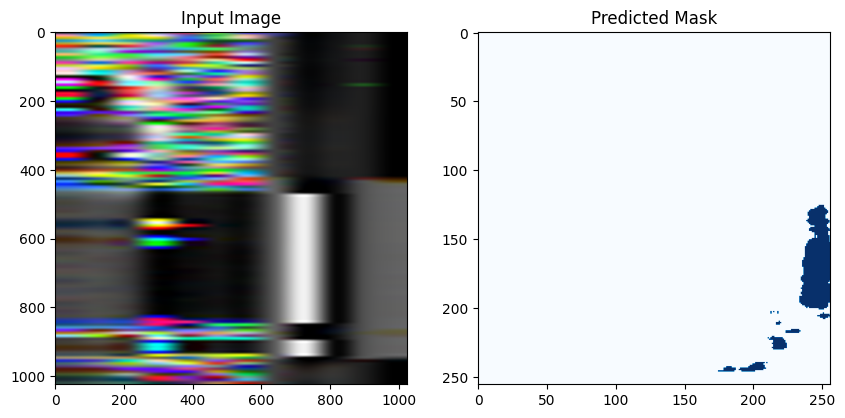

In [28]:
test_image_path = "data/images/210.tif"  # Change to a real test image path

image, pred_mask = predict_segmentation(test_image_path)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="Blues")  # Display predicted mask
plt.title("Predicted Mask")

plt.show()


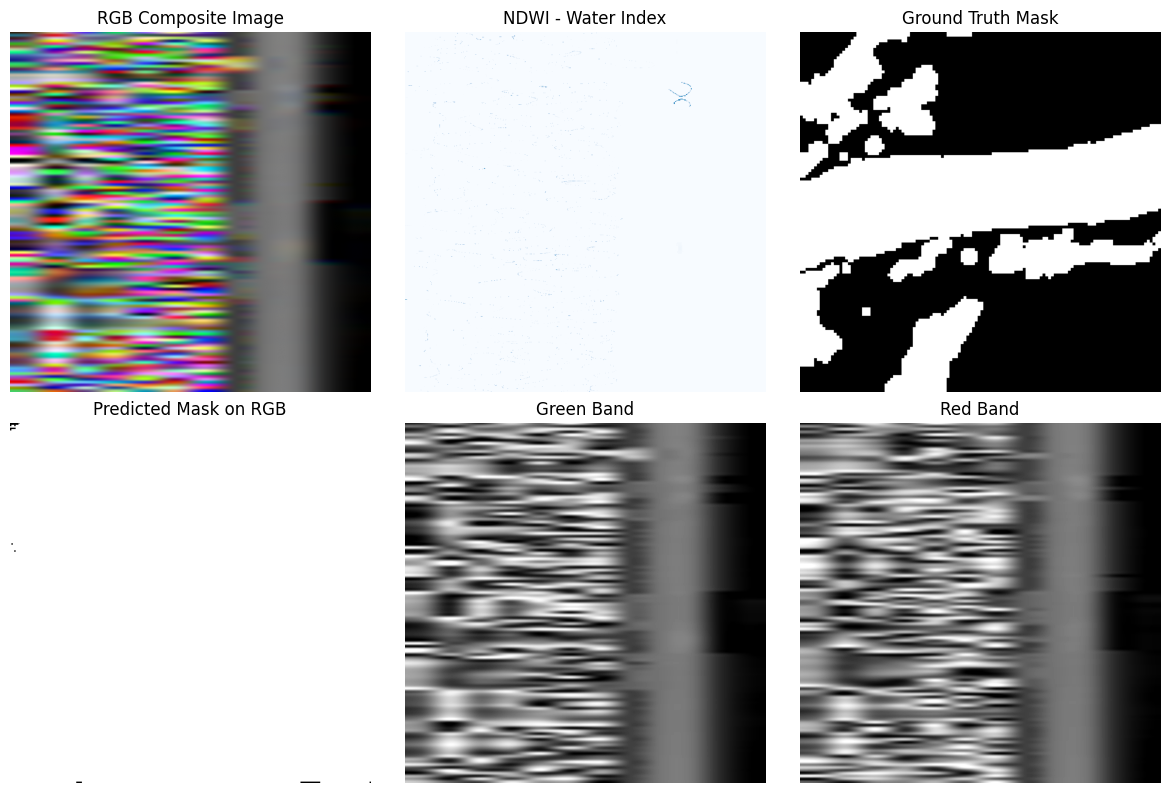

In [45]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import tifffile as tiff

# === CONFIGURATION ===
MODEL_DIR = "segformer_waterbody_output"  # Path to saved model
IMAGE_SIZE = (1024, 1024)  # Resize all images
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === LOAD MODEL & PROCESSOR ===
processor = SegformerImageProcessor.from_pretrained(MODEL_DIR)
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()  # Set to evaluation mode

# === IMAGE PREPROCESSING FUNCTION ===
def preprocess_image(image_path):
    """Loads a TIFF image, ensures 3-channel RGB, and processes it."""
    image = tiff.imread(image_path)

    # Ensure image has exactly 3 channels (RGB)
    if image.shape[0] >= 3:
        image = image[:3, :, :]  # Take the first 3 channels
    else:
        raise ValueError(f"Image has only {image.shape[0]} channels. Expecting at least 3.")

    image = np.transpose(image, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
    image = Image.fromarray(image.astype(np.uint8)).resize(IMAGE_SIZE)  # Convert to PIL and resize
    
    # Normalize and process image for Segformer
    encoding = processor(image, return_tensors="pt")
    encoding["pixel_values"] = encoding["pixel_values"].to(DEVICE)

    return image, encoding

# === PREDICTION FUNCTION ===
def predict_segmentation(image_path):
    """Predicts a segmentation mask using the trained Segformer model."""
    image, encoding = preprocess_image(image_path)

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits  # Shape: (batch_size, num_classes, H, W)
        probs = F.softmax(logits, dim=1)  # Convert to probabilities
        pred_mask = torch.argmax(probs, dim=1).squeeze().cpu().numpy()  # Get predicted mask

    return np.array(image), pred_mask

# === VISUALIZATION FUNCTION ===
def plot_heatmap(image, mask_true, mask_pred):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Show RGB composite image
    rgb_image = np.clip(image[:, :, :3] / 255.0, 0, 1)  # Normalize for display
    axes[0, 0].imshow(rgb_image)
    axes[0, 0].set_title("RGB Composite Image")
    axes[0, 0].axis("off")

    # NDWI Heatmap (Example calculation)
    ndwi = (image[:, :, 1] - image[:, :, 2]) / (image[:, :, 1] + image[:, :, 2] + 1e-10)
    axes[0, 1].imshow(ndwi, cmap="Blues")
    axes[0, 1].set_title("NDWI - Water Index")
    axes[0, 1].axis("off")

    # Ground Truth Mask
    axes[0, 2].imshow(mask_true.squeeze(), cmap="gray")
    axes[0, 2].set_title("Ground Truth Mask")
    axes[0, 2].axis("off")

    # Predicted Mask Overlay
    axes[1, 0].imshow(rgb_image)
    axes[1, 0].imshow(mask_pred.squeeze(), cmap="gray")
    axes[1, 0].set_title("Predicted Mask on RGB")
    axes[1, 0].axis("off")

    # Show grayscale bands
    axes[1, 1].imshow(image[:, :, 1], cmap="gray")  # Green band
    axes[1, 1].set_title("Green Band")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(image[:, :, 2], cmap="gray")  # Red band
    axes[1, 2].set_title("Red Band")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

# === RUN PREDICTION ===
test_image_path = "data/images/100.tif"  # Change to your image path
test_mask_path = "data/filtered_labels/100.png"  # Change to your ground truth mask

image, pred_mask = predict_segmentation(test_image_path)
true_mask = np.array(Image.open(test_mask_path).convert("L").resize(IMAGE_SIZE))  # Load ground truth

# === DISPLAY RESULTS ===
plot_heatmap(image, true_mask, pred_mask)
